# Reinforcement Learning Notebook - Get expert trajectories - Pendulum-v0

In [2]:
import gym
import numpy as np
import cvxpy as cp
import sys
import pylab
import pandas as pd 
import torch
from torch.autograd import Variable
import copy
import torch.nn.functional as F
import random
import torch.nn as nn
import math
from itertools import count
from PIL import Image
import torch
import torch.optim 
import torchvision.transforms as transforms
from collections import namedtuple, deque
from torch import nn
from gym import make
import torch.optim as optim
from numpy import save
from tqdm.notebook import tqdm
import pickle
from typing import Optional
import IPython
from IPython.display import set_matplotlib_formats; set_matplotlib_formats('svg')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [10]:
from Code.utils import Net, Agent, Memory
from Code.plotting import preprocess_states, animate

### DQN - Save expert trajectories

In [4]:
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

In [5]:
def main(environment):
    environment = 'Pendulum-v0' 
    env = gym.make(environment)

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.shape[0]
    action_dim = env.action_space.shape[0] * 5 #discretization  of the unique continuous action of the pendulum

    agent = Agent(input_dim, output_dim, action_dim, environment)

    training_records = []
    running_reward, running_q = -1000, 0

    full_trajs = [] #supposed to be a list of arrays that will save several expert traj
    episodes = 60

    for i_ep in range(episodes):
        score = 0
        
        #We fix the departure state 
        state = env.reset()
        env.env.state = np.array([np.pi/2, 0.5])
        env.env.last_u = None
        state = env.env._get_obs()
        
        #to make it more robust we have to use :
        #state = env.reset()
        
        full_traj = state.reshape(1,-1)
        for t in range(1, 200):
            action, action_index = agent.select_action(state)
            state_, reward, done, _ = env.step(action)
            full_traj = np.concatenate((full_traj, np.array(state_).reshape(1,-1)))
            score += reward

            env.render()
            agent.store_transition(Transition(state, action_index, (reward + 8) / 8, state_))
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

        running_reward = running_reward * 0.9 + score * 0.1
        training_records.append(TrainingRecord(i_ep, running_reward))

        print('Ep', i_ep, 'Average score:', running_reward, 'score of current env', score )
        
        if i_ep > episodes - 3:
            full_trajs.append(full_traj)


    agent.save_param()
    with open('/Users/ilanasebag/Documents/Thesis_Code/RL_results/dqn_training_records_%s.pkl'%environment, 'wb') as f:
        pickle.dump(training_records, f)
        
            
    save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_exp_states_%s.npy'%environment,full_trajs[-1])
    save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/multi_exp_states_%s.npy'%environment,full_trajs)

    env.close()

    plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
    plt.title('DQN reward curve')
    plt.xlabel('Episode')
    plt.ylabel('Moving averaged episode reward')
    plt.savefig("/Users/ilanasebag/Documents/Thesis_Code/RL_results/dqn_%s.png"%environment)
    plt.show()


Ep 0 Average score: -1017.5482250555058 score of current env -1175.4822505550571
Ep 1 Average score: -1058.1594008991297 score of current env -1423.659983491745
Ep 2 Average score: -1088.2569011605087 score of current env -1359.1344035129196
Ep 3 Average score: -1115.8623127314984 score of current env -1364.311016870405
Ep 4 Average score: -1151.450478894346 score of current env -1471.743974359974
Ep 5 Average score: -1173.2473937926725 score of current env -1369.419627877611
Ep 6 Average score: -1186.9272571792003 score of current env -1310.0460276579497
Ep 7 Average score: -1201.896176314334 score of current env -1336.6164485305385
Ep 8 Average score: -1200.0059963869737 score of current env -1182.9943770407285
Ep 9 Average score: -1227.9308602786332 score of current env -1479.2546353035693


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -1241.2866298272888 score of current env -1361.4885557651874
Ep 11 Average score: -1254.2243124182023 score of current env -1370.663455736424
Ep 12 Average score: -1255.678599262799 score of current env -1268.7671808641694
Ep 13 Average score: -1276.9470109014014 score of current env -1468.3627156488221
Ep 14 Average score: -1295.5526724884683 score of current env -1463.003626772069
Ep 15 Average score: -1311.3663680698307 score of current env -1453.6896283020928
Ep 16 Average score: -1313.5672088699837 score of current env -1333.37477607136
Ep 17 Average score: -1321.6648891396721 score of current env -1394.5440115668673
Ep 18 Average score: -1331.977498917628 score of current env -1424.790986919231
Ep 19 Average score: -1293.965095539647 score of current env -951.853465137817
Ep 20 Average score: -1271.2738364047614 score of current env -1067.0525041907888
Ep 21 Average score: -1223.5100405271899 score of current env -793.6358776290473
Ep 22 Average score: -1205.

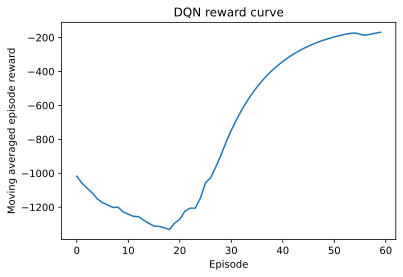

In [6]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    main(environment)

### Check shapes after saving and reloading trajectories 

In [7]:
environment = 'Pendulum-v0'
simple_exp = np.load ('/Users/ilanasebag/Documents/Thesis_code/RL_results/simple_exp_states_%s.npy'%environment,
                  allow_pickle = True)
multi_exp = np.load ('/Users/ilanasebag/Documents/Thesis_code/RL_results/multi_exp_states_%s.npy'%environment,
                  allow_pickle = True)

print(simple_exp.shape)
print(multi_exp.shape)

(200, 3)
(2, 200, 3)


### Visualization

##### multi_exp

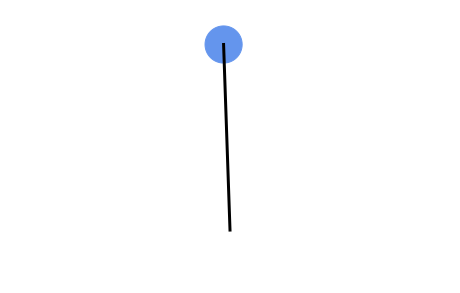

In [11]:
#first trajectory saved 
states = preprocess_states(multi_exp[0])
animate(states)

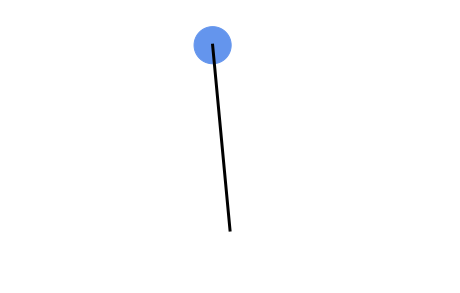

In [13]:
#second trajectory saved 
states = preprocess_states(multi_exp[1])
animate(states)

##### simple_exp

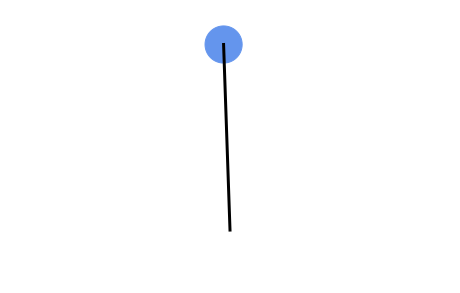

In [15]:
#unique trajectory saved 
states = preprocess_states(multi_exp[0])
animate(states)